# Left-handed people mortality
---------------

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

In [2]:
url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(url_1)
lefthanded_data.head()

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906


### Left-handedness rates vs. age [grouped by sex]

Text(0, 0.5, 'Left-handedness rates')

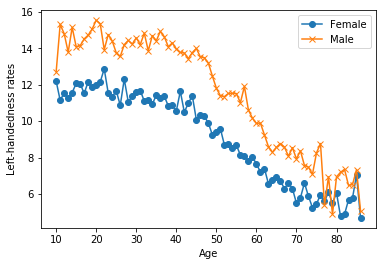

In [3]:
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot("Age", "Female", data=lefthanded_data, marker = 'o') # plot "Female" vs. "Age"
ax.plot("Age", "Male", data=lefthanded_data, marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Left-handedness rates")

## Rates of left-handedness over time

Let's plot average rates of left-handedness over male and female as a function of the year of birth.
Since the study was done in 1986, the data after this conversion will be the percentage of people alive in 1986 who are left-handed as a function of the year they were born.

In [14]:
# Column for birth year of each age
lefthanded_data["Birth_year"] = 1986 - lefthanded_data["Age"]

In [15]:
# Column for the average of male and female lh rates
lefthanded_data["Mean_lh"] = lefthanded_data[["Female","Male"]].mean(axis=1)

Text(0, 0.5, 'Mean_lh')

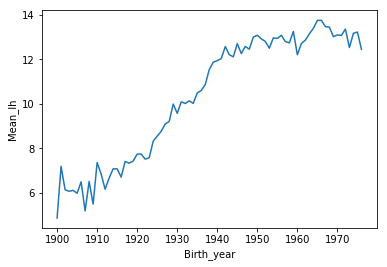

In [16]:
# Plot
fig, ax = plt.subplots()
ax.plot("Birth_year", "Mean_lh", data=lefthanded_data) # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel("Birth_year") # set the x label for the plot
ax.set_ylabel("Mean_lh") # set the y label for the plot

## Applying Bayes' theorem
Bayes' theorem is a statement about conditional probability which allows us to update our beliefs after seeing evidence:
> The probability of outcome or event A, given that outcome or event B has happened (or is true) is not the same as the probability of outcome B given that outcome A has happened. 

We need to take into account the _prior probability_ that A has happened (the probability that A has happened is written P(A)). Bayes' rule can be written as follows:
$$P(A | B) = \frac{P(B|A) P(A)}{P(B)}$$

In our case, we want to calculate the probability of dying at a particular age A, _given that_ you're left-handed:
$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$

where $P(LH | A)$ is the probability that you are left-handed <em>given that</em> you died at age A. 
$P(A)$ is the overall probability of dying at age A, and P(LH) is the overall probability of being left-handed. 

To calculate $P(LH | A)$ for ages that might fall outside the original data, we will need to extrapolate the data to earlier and later years. 

We also want the same quantity for right-handers: P(A | RH). We will figure out what difference in age of death we might expect purely from the changing rates of left-handedness plotted above.

In [17]:
import numpy as np

# Create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data["Mean_lh"][-10:].mean() 
    late_1900s_rate = lefthanded_data["Mean_lh"][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86
    
    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate/100
    P_return[ages_of_death < youngest_age] = late_1900s_rate/100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates/100

    return P_return

## When do people normally die?

To estimate the probability of living to an age A, we can use data that give the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution that gives the probability of dying at age A. 

The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. We'll now load in the death distribution data and plot it. 

In [21]:
# Death distribution data for the United States in 1999
url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# Loading
death_distribution_data = pd.read_csv(url_2, sep = "\t", skiprows=[1])
death_distribution_data.head()

,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0


In [22]:
death_distribution_data.tail()

,Age,Both Sexes,Male,Female
120,120,1.0,NaN,1.0
121,121,NaN,NaN,NaN
122,122,NaN,NaN,NaN
123,123,NaN,NaN,NaN
124,124,NaN,NaN,NaN


In [24]:
# Drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset = ["Both Sexes"])

Text(0.5, 0, 'Age')

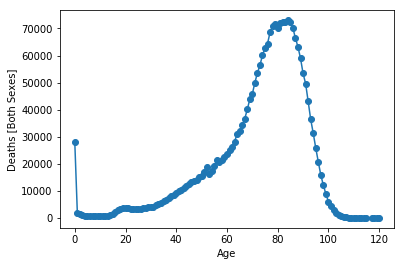

In [25]:
# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot("Age", "Both Sexes", data = death_distribution_data, marker='o') # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel("Age")
ax.set_ylabel("Deaths [Both Sexes]") 

## The overall probability of left-handedness
We loaded data to give us P(A), and now we need P(LH), i.e. the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. 

This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where $N(A)$ is the number of people who died at age $A$ (given by the dataframe <code>death_distribution_data</code>):

$$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$ 

In [26]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    # multiply number of dead people by P_lh_given_A
    p_list = P_lh_given_A(death_distribution_data["Age"], study_year) * death_distribution_data["Both Sexes"]
    p = np.sum(p_list) # calculate the sum of p_list
    # normalize to total number of people (sum of death_distribution_data['Both Sexes'])
    return p/np.sum(death_distribution_data["Both Sexes"]) 

print(P_lh(death_distribution_data, 1990))

0.07766387615350638


## Dying while left-handed
Now we have the means of calculating all three quantities we need: 
    - $P(A)$, 
    - $P(LH)$, 
    - $P(LH | A)$. 
    
We can combine all three using Bayes' rule to get $P(A | LH)$, i.e. the probability of being age A at death (in the study year) given that you're left-handed. We also want to compare it to $P(A | RH)$, the probability of being age A at death given that you're right-handed:
$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$
First, for left-handers.

In [27]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death]/np.sum(death_distribution_data["Both Sexes"])
    
    # use P_lh function to get probability of left-handedness overall
    P_left = P_lh(death_distribution_data, study_year) 
    
    # use P_lh_given_A to get probability of left-handedness for a certain age
    P_lh_A = P_lh_given_A(ages_of_death, study_year)  
    
    return P_lh_A*P_A/P_left

And now for right-handers.

In [28]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data["Both Sexes"][ages_of_death]/np.sum(death_distribution_data["Both Sexes"])
    # either you're left-handed or right-handed, so P_right = 1 - P_left
    P_right = 1 - P_lh(death_distribution_data, study_year)
    # P_rh_A = 1 - P_lh_A 
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year) 
    return P_rh_A*P_A/P_right

## Plotting the distributions of conditional probabilities
Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120.

In [30]:
# make a list of ages of death to plot
ages = np.arange(6, 120) 

ages

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119])

In [33]:
# calculate the probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

right_handed_probability.head()

6     0.000274
7     0.000269
8     0.000273
9     0.000252
10    0.000271
Name: Both Sexes, dtype: float64

Text(0, 0.5, 'Probability of being age A at death')

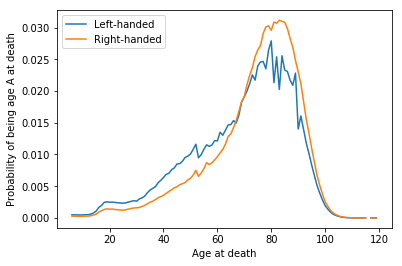

In [35]:
# create a plot of the two probabilities vs. age
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend() # add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel("Probability of being age A at death")

Notice that the **left-handed distribution has a bump below age 70**: of the pool of deceased people, left-handed people are more likely to be younger.

## Age of left and right-handers at death
Let's compare our results with the original study that found that left-handed people were nine years younger at death on average. 

We can do this by calculating the mean of these probability distributions in the same way we calculated $P(LH)$ earlier, weighting the probability distribution by age and summing over the result.
$$\text{Average age of left-handed people at death} = \sum_A A\ P(A | LH)$$
$$\text{Average age of right-handed people at death} = \sum_A A\ P(A | RH)$$

In [36]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

In [38]:
# print the average ages for each group
print("Average age of lefthanded:\t" + str(average_lh_age))
print("Average age of righthanded:\t" + str(average_rh_age))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_lh_age - average_rh_age, 1)) + " years.")

Average age of lefthanded:	67.24537694089135
Average age of righthanded:	72.79216773254639
The difference in average ages is -5.5 years.


## Conclusion

- We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: you probably won't die young because of your sinisterness. The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers.
- Our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: </p>
<ol>
<li>We used death distribution data from almost ten years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). </li>
<li>We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. </li>
</ol>

## Next steps

- Figure out how much variability we would expect to encounter in the age difference purely because of random sampling: if you take a smaller sample of recently deceased people and assign handedness with the probabilities of the survey, what does that distribution look like? How often would we encounter an age gap of nine years using the same data and assumptions? We won't do that here, but it's possible with this data and the tools of random sampling.
- Calculate the age gap we'd expect if we did the study in 2018 instead of in 1990. The gap turns out to be much smaller since rates of left-handedness haven't increased for people born after about 1960. Both the National Geographic study and the 1990 study happened at a unique time - the rates of left-handedness had been changing across the lifetimes of most people alive, and the difference in handedness between old and young was at its most striking.

In [39]:
# Calculate the probability of being left- or right-handed for all ages
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, 2018)

# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 = np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages*np.array(right_handed_probability_2018))


# print the average ages for each group
print("Average age of lefthanded:\t" + str(average_lh_age_2018))
print("Average age of righthanded:\t" + str(average_rh_age_2018))

print("The difference in average ages is " + 
      str(round(average_lh_age_2018 - average_rh_age_2018, 1)) + " years.")

Average age of lefthanded:	70.28797498782241
Average age of righthanded:	72.62946251206667
The difference in average ages is -2.3 years.
